<a href="https://colab.research.google.com/github/csralvall/online_game_toxicity/blob/main/clustering_ftt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import utility functions

In [ ]:
from IPython.display import clear_output

### Install dependencies

In [ ]:
# install dependencies
!pip install -U pip setuptools wheel pandas numpy gensim wget
clear_output()

### Import libraries

In [90]:
# import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import pickle
import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models import FastText

### Setup dataframe print options

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Mount storage

In [ ]:
# mount google drive unit to save computationally expensive results
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load subset of whole dataset from storage

In [ ]:
# english chats from original dataset with anotations
eng_annotated = '/content/drive/MyDrive/nlp/dota2_chat_eng_annotated.csv'
df_test = pd.read_csv(eng_annotated)[:10000]

### Get bad word list from memory

In [ ]:
# get downloaded bad word list
word_list = "/content/drive/MyDrive/nlp/bad_words.txt"
# use set for fast queries
bad_words = set(line.strip() for line in open(word_list, 'r'))
# add new bad words
bad_words.update(['noob', 'noobs', 'stfu', 'fukign', 'fuking', 'fukin', 'nooob'])
bad_dict = dict.fromkeys(bad_words, 0)

#### Fasttext embeddings:

In [ ]:
# function to create embeddings of words in each chat
def generate_embedding_ftt(sentences: [[str]]):
  ftt_model = FastText(
      sentences=sentences,
      vector_size=100,
      window=5,
      min_count=1,
      workers=1
  )

  ftt_model.build_vocab(sentences, progress_per=10000)

  ftt_model.train(sentences, total_examples=len(sentences), epochs=100)

  return ftt_model

### Unroll chats as list of words

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
# from cleaned english chats get all of them without nan values
chats = df_test[['tokens']].dropna().astype(str).values
chats = flatten(chats)
vocab = list(map(lambda x: x.split(), chats))

### Generate word embeddings from chat

In [ ]:
ftt_model = generate_embedding_ftt(vocab)

In [ ]:
# save FastText model
ftt_model.save('/content/drive/MyDrive/nlp/fasttext.model')

### Load word embeddings from disk

In [ ]:
# load FastText model
ftt_model = FastText.load('/content/drive/MyDrive/nlp/fasttext.model')

### Embeddings utils

In [ ]:
# generate embedding from chat
def chat_embedding(model, chat_words):
    chat_embedding = np.ones(100)
    for word in chat_words:
        if word in model.wv:
            chat_embedding *= model.wv[word] 
    return chat_embedding

### Clustering utils

In [ ]:
def get_bad_vec(lexicon, chat_words):
    for word in chat_words:
        if word in lexicon:
            bad_dict[word] += 1

    bad_vec = np.fromiter(bad_dict.values(), dtype=int)
    
    return bad_vec

In [ ]:
def get_bow_vec(bow, chat_words):
    for word in word_list:
        if word in bow:
            bow[word] += 1

    bow_vec = np.fromiter(bow.values(), dtype=int)

    return bow_vec

In [ ]:
intensity = df_test[['intensity']].copy()

### Create ftt vectors for clustering

In [ ]:
ftt_serie = np.array([])
for idx, chat in enumerate(chats):
    lexicon = dict.fromkeys(bad_words, 0)
    chat_intensity = intensity.loc[idx]
    chat_words = chat.split()
    bad_vec = get_bad_vec(lexicon, chat_words)
    ftt_embedding = chat_embedding(ftt_model, chat_words)
    ftt_bad_int_vec = np.hstack((ftt_embedding, bad_vec, chat_intensity)).ravel()
    ftt_serie = np.concatenate((ftt_serie, ftt_bad_int_vec))

### Reshape data

In [ ]:
ftt_ncolumns = ftt_model.wv.vectors.shape[1] + len(bad_words) + 1
ftt_serie = ftt_serie.astype('float').reshape((-1, ftt_ncolumns))
ftt_matrix = ftt_serie[~np.isnan(ftt_serie)].reshape((-1, ftt_ncolumns))

### Matrix reduction

In [ ]:
def reduce_matrix(matrix: np.ndarray, *, variance_treshold: float):
    print(f'INPUT SHAPE: {matrix.shape}')
    # reduce all vectors to [0, 1] space
    normalized_matrix = normalize(matrix, axis=1)
    # compute variances in each row
    matrix_variances = np.var(matrix, axis=0)
    # create mask for features with high correlation (low variance)
    bool_mask = np.where(matrix_variances < variance_treshold)
    # filter features with high correlation (variance under treshold)
    raked_matrix = np.delete(normalized_matrix, bool_mask, axis=1)
    print(f'OUTPUT SHAPE: {raked_matrix.shape}')
    return raked_matrix

In [ ]:
ftt_reduced = reduce_matrix(ftt_matrix, variance_treshold=0.01)

INPUT SHAPE: (8157, 1492)
OUTPUT SHAPE: (8157, 239)


### Save matrix

In [ ]:
with open('/content/drive/MyDrive/nlp/ftt_serie_10000.npy', 'wb') as output_file:
    np.save(output_file, ftt_reduced)

### Load matrix from storage

In [ ]:
ftt_reduced = np.load('/content/drive/MyDrive/nlp/ftt_serie_10000.npy')

### Clustering

In [ ]:
def generate_clusters(
    matrix: np.ndarray,
    n_clusters: int
) -> KMeans:
    # generate word clusters using the KMeans algorithm.
    print("\nClustering started")
    # Instantiate KMeans clusterer for n_clusters
    km_model = KMeans(n_clusters=n_clusters, random_state=3)
    # create clusters
    km_model.fit(matrix)
    print("Clustering finished")
    return km_model

### Create clusters

In [ ]:
ftt_clusters = generate_clusters(ftt_reduced, 50)


Clustering started
Clustering finished


### Cluster utility functions

In [ ]:
def display_summary(clusters: KMeans):
    cluster_count = Counter(sorted(clusters.labels_))
    for cluster in cluster_count:
        print ("Cluster#", cluster," - Total words:", cluster_count[cluster])

In [ ]:
def annotate_dataframe(clusters: KMeans, df: pd.DataFrame, col_name: str):
    cluster_count = Counter(sorted(clusters.labels_))
    #sort cluster centers by proximity to centroid
    order_centroids = clusters.cluster_centers_.argsort()[:, ::-1] 

    clusters_df = np.zeros(len(df))
    
    for cluster_idx in cluster_count:
        # get words inside each cluster
        cluster_words = np.where(clusters.labels_ == cluster_idx)[0]
        # anotate all chats in cluster
        for idx in cluster_words:
            clusters_df[idx] = int(cluster_idx)

    df[col_name] = clusters_df

### Show info about clusters

In [ ]:
display_summary(ftt_clusters)

Cluster# 0  - Total words: 1620
Cluster# 1  - Total words: 42
Cluster# 2  - Total words: 293
Cluster# 3  - Total words: 16
Cluster# 4  - Total words: 61
Cluster# 5  - Total words: 16
Cluster# 6  - Total words: 32
Cluster# 7  - Total words: 26
Cluster# 8  - Total words: 565
Cluster# 9  - Total words: 18
Cluster# 10  - Total words: 20
Cluster# 11  - Total words: 47
Cluster# 12  - Total words: 34
Cluster# 13  - Total words: 2018
Cluster# 14  - Total words: 375
Cluster# 15  - Total words: 11
Cluster# 16  - Total words: 62
Cluster# 17  - Total words: 38
Cluster# 18  - Total words: 333
Cluster# 19  - Total words: 19
Cluster# 20  - Total words: 121
Cluster# 21  - Total words: 17
Cluster# 22  - Total words: 47
Cluster# 23  - Total words: 164
Cluster# 24  - Total words: 45
Cluster# 25  - Total words: 8
Cluster# 26  - Total words: 600
Cluster# 27  - Total words: 58
Cluster# 28  - Total words: 5
Cluster# 29  - Total words: 34
Cluster# 30  - Total words: 28
Cluster# 31  - Total words: 27
Cluster# 

### Annotate cluster for each row in dataframe

In [ ]:
df_test = df_test.copy()

In [ ]:
annotate_dataframe(ftt_clusters, df_test, 'ftt_clusters')

In [ ]:
df_test.to_csv(f'/content/drive/MyDrive/nlp/ftt_clusters_df.csv', index=False)

### Load FastText clusters

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/nlp/ftt_clusters_df.csv')

### Explore results

In [ ]:
ftt_group = df_test.groupby('ftt_clusters')

Get toxicity score for each cluster

In [ ]:
ftt_score = (ftt_group['toxicity'].sum() / ftt_group.size())

In [ ]:
ftt_scored = pd.DataFrame({'score': ftt_score.values, 'size': ftt_group.size()})
ftt_scored = ftt_scored[ftt_scored['score'] > 0.2]
ftt_scored = ftt_scored.sort_values(by=['score', 'size'], ascending=[False, False])
top_toxic_clusters = ftt_scored.index.to_list()
ftt_scored

,score,size
ftt_clusters,,
15.0,0.363636,11
35.0,0.333333,3
39.0,0.236842,38
34.0,0.228571,35
1.0,0.214286,42
4.0,0.213115,61


### Explore clusters

In [ ]:
ftt_group.get_group(15)[['match','text']]

,match,text
27,6,i killed u
36,6,commended
975,130,u can end
1162,160,legion stop fedd noob
1260,173,lol
2071,294,pathetic AM pick in unranked
2226,316,suicide.exe
2391,335,lol
2508,362,already dead
5489,865,GGWP


In [ ]:
ftt_group.get_group(4)[['match','text']]

,match,text
520,82,Support my ass senpai
552,82,and pum pum pudrrr pum
589,83,fuck dog to born ?
644,101,REPORT PUDGE
826,121,let the faggot be happy with his imba hero cou...
938,123,WHY FEED?
1035,146,idiot lol
1037,146,lol
1078,149,only that
1261,173,El rubick hase nice hock's


In [ ]:
ftt_group.get_group(35)[['match','text']]

,match,text
5064,798,pls report jakiro
5065,798,very noob
5093,807,tx


In [ ]:
ftt_group.get_group(39)[['match','text']]

,match,text
820,120,Fashiki ebanie
822,121,fucking danny
865,121,she is not 18 yet
959,125,end
989,132,GG WP
1005,140,skill bruh
1097,152,team
1115,153,funny situation
1366,183,tacotaco
1452,194,good game :S


In [ ]:
ftt_group.get_group(34)[['match','text']]

,match,text
98,13,fuckkk youuuuu
122,20,:*
126,22,happy no cour day
129,22,sure
367,55,OFBI
539,82,lucky u
595,83,a dog cant bark
603,83,Dont kill the dog
686,107,injoker
849,121,nice one


### Reduce dimensionality to display data

In [ ]:
# use TSNE to reduce dimensionality of data
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(ftt_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Display data without clusters

In [ ]:
pointsspacy = pd.DataFrame(
    [(chat, coord[0], coord[1]) for (chat, coord) in zip(chats, matrix_dicc2d)],
    columns=["word", "x", "y"]
)

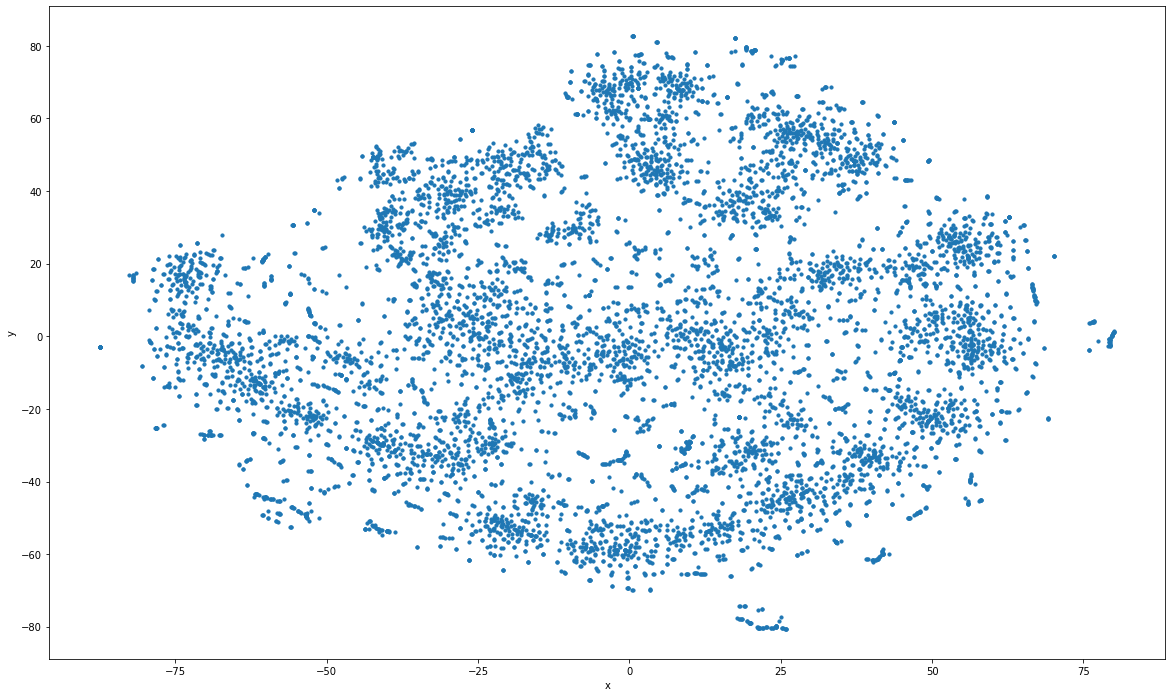

In [ ]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Display clusters and clusters with biggest proportion of toxic words

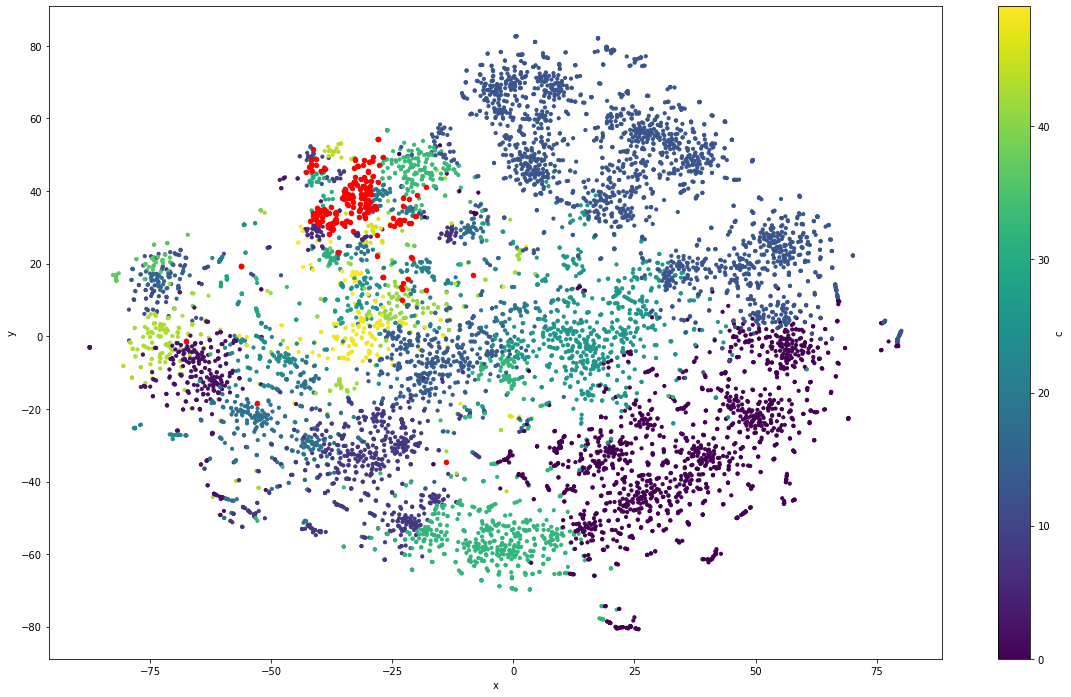

In [ ]:
fig, ax = plt.subplots()
pointscluster = pd.DataFrame(
    [(chat, coord[0], coord[1], cluster) for (chat, coord, cluster) in zip(df_test['clean'], matrix_dicc2d, df_test['ftt_clusters']) ],
    columns=["word", "x", "y", "c"]
)
pointscluster.plot(ax=ax, kind='scatter', x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))
toxic_clusters = pd.DataFrame(
    [(coord[0], coord[1]) for (coord, cluster) in zip(matrix_dicc2d, df_test['ftt_clusters']) if cluster in top_toxic_clusters ],
    columns=["x", "y"]
)
toxic_clusters.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
plt.show()